In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score



random.seed(1)

In [38]:
df = pd.read_csv("btsusd.csv")

In [39]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
#добавляем столбцы от даты
df["year"] = pd.to_datetime(df["Timestamp"], unit = "s").dt.year
df["month"] = pd.to_datetime(df["Timestamp"], unit = "s").dt.month
df["day"] = pd.to_datetime(df["Timestamp"], unit = "s").dt.day
df["hour"] = pd.to_datetime(df["Timestamp"], unit = "s").dt.hour
df["minute"] = pd.to_datetime(df["Timestamp"], unit = "s").dt.minute

In [5]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,year,month,day,hour,minute
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,7,52
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,7,53
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,7,54
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,7,55
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,7,56


In [50]:
#убираем все данные до 2017 года из за малой информативности и другого поведения рынка
df = df[df["year"]>2016]

In [51]:
df = df.dropna()

In [52]:
df = df.drop(columns = "Timestamp")

In [53]:
#добавляем столбец таргета, который говорит, подняласть ли цена более чем на 0.5% за минуту, или нет
df["target"] = ((df["High"]-df["Open"])/df["Open"])>= 0.005

In [10]:
#записываем индексы записей, когда цена поднялась больше чем на 0.5%
indexes = []
for index in range(df.shape[0]):
    if df.iloc[index].target == True:
        indexes.append(index)

In [11]:
print(len(indexes))

16735


In [12]:
#задаем рандомные индексы, для того, чтобы в выборке были зачения таргета false. Рандомные, потому что значений true 0.8%
false_indexes = []
for i in range(20000):
    false_indexes.append(random.randint(16,df.shape[0]))
print(len(false_indexes))

20000


In [13]:
X = df.drop(columns = ["year","target"])
y = df.drop(columns = ["Open", "High", "Low", "Close", "Volume_(BTC)", "Volume_(Currency)", "Weighted_Price", "year", "month", "day", "hour", "minute"])

In [14]:
X.shape

(1861137, 11)

In [15]:
X.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,month,day,hour,minute
2625377,966.34,966.34,966.34,966.34,7.610000,7353.847400,966.340000,1,1,0,1
2625378,966.16,966.37,966.16,966.37,8.087376,7814.876061,966.305479,1,1,0,2
2625381,966.43,966.43,966.43,966.43,0.107000,103.408010,966.430000,1,1,0,5
2625382,966.58,966.58,966.58,966.58,0.331732,320.645952,966.580000,1,1,0,6
2625386,966.57,966.57,966.57,966.57,0.695563,672.310754,966.570000,1,1,0,10


In [16]:
X.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'month', 'day', 'hour', 'minute'],
      dtype='object')

In [17]:
#стандартизируем данные для нейронной сети
scaler = MinMaxScaler()
X_new = scaler.fit_transform(X)

In [18]:
X_new = pd.DataFrame(data = X_new, columns = X.columns)

In [19]:
X_new.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,month,day,hour,minute
0,0.011332,0.011290,0.011376,0.011330,0.004709,0.000704,0.011334,0.0,0.0,0.0,0.016949
1,0.011323,0.011292,0.011367,0.011332,0.005004,0.000748,0.011332,0.0,0.0,0.0,0.033898
2,0.011337,0.011295,0.011381,0.011335,0.000066,0.000010,0.011339,0.0,0.0,0.0,0.084746
3,0.011345,0.011303,0.011389,0.011343,0.000205,0.000031,0.011347,0.0,0.0,0.0,0.101695
4,0.011345,0.011302,0.011389,0.011343,0.000430,0.000064,0.011346,0.0,0.0,0.0,0.169492


In [20]:
#определяем функцию, которая будет создавать датасет нужного формата для многомерного анализа временных рядов
def create_dataset(dataframe, dataframe_y, indexes, look_back):
    data = []
    target = []
    
    for index in indexes:
        data.append(np.array(dataframe.iloc[index-look_back:index].values))
        target.append(dataframe_y.iloc[index].target)
    return data,target

In [21]:
X_true, y_true = create_dataset(X_new,y,indexes, 15)
X_false, y_false = create_dataset(X_new, y, false_indexes, 15)

In [22]:
print(len(X_true)*0.3, len(X_false)*0.3)
print(len(X_true), len(X_false))

5020.5 6000.0
16735 20000


In [23]:
#разбиваем на обучающуб, валидационную и тестовую выборки
X_train = X_true[:11000] + X_false[:15000]
y_train = y_true[:11000] + y_false[:15000]
X_valid = X_true[11000:14000] + X_false[15000:18000]
y_valid = y_true[11000:14000] + y_false[15000:18000]
X_test = X_true[14000:] + X_false[18000:]
y_test = y_true[14000:] + y_false[18000:]

In [24]:
#приводим к нужному типу, размеру и формату
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)

In [26]:
X_train = np.reshape(X_train, (X_train.shape[0],15,11))
X_valid = np.reshape(X_valid, (X_valid.shape[0],15,11))
X_test = np.reshape(X_test, (X_test.shape[0],15,11))

In [27]:
X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
X_test = X_test.astype("float32")

In [28]:
#определяем колбеки, создаем модель, обучаем
filepath = "check.h5"
call = ModelCheckpoint(filepath, monitor = "val_precision", save_best_only = True, save_weights_only = True)

call2 = EarlyStopping(
    restore_best_weights = True,
    min_delta = 1,
    patience = 2
)

In [29]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.LSTM(64, activation = "relu", input_shape = (15,11)),
    layers.Dropout(rate = 0.3),
    layers.Dense(1, activation = "sigmoid")
])

model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = ["Precision", "binary_accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size = 32, epochs = 5,
    callbacks = [call],
    shuffle = True
)

Epoch 1/5
813/813 [==============================] - 9s 11ms/step - loss: 0.4255 - precision: 0.7825 - binary_accuracy: 0.8081 - val_loss: 1.0836 - val_precision: 0.7518 - val_binary_accuracy: 0.6250
Epoch 2/5
813/813 [==============================] - 8s 10ms/step - loss: 0.3664 - precision: 0.8061 - binary_accuracy: 0.8376 - val_loss: 1.2675 - val_precision: 0.7759 - val_binary_accuracy: 0.6350
Epoch 3/5
813/813 [==============================] - 8s 9ms/step - loss: 0.3544 - precision: 0.8090 - binary_accuracy: 0.8418 - val_loss: 1.3514 - val_precision: 0.7181 - val_binary_accuracy: 0.5910
Epoch 4/5
813/813 [==============================] - 8s 10ms/step - loss: 0.3444 - precision: 0.8150 - binary_accuracy: 0.8476 - val_loss: 1.4723 - val_precision: 0.6658 - val_binary_accuracy: 0.5625
Epoch 5/5
813/813 [==============================] - 8s 9ms/step - loss: 0.3364 - precision: 0.8162 - binary_accuracy: 0.8518 - val_loss: 1.5175 - val_precision: 0.5921 - val_binary_accuracy: 0.5230


In [30]:
#оцениваем лучшую модель на тестовом множестве
pred = model.predict(X_test)
res = []
for i in pred:
    if i>=0.5:
        res.append(True)
    else:
        res.append(False)
print(precision_score(y_test, res))

0.8414948453608248


In [31]:
print(sum(y_test))
print(sum(pred))

2756
[1626.1714]


In [32]:
history_df = pd.DataFrame(data = history.history)

In [33]:
history_df.head()

,loss,precision,binary_accuracy,val_loss,val_precision,val_binary_accuracy
0,0.425534,0.782465,0.808077,1.083567,0.751787,0.6250
1,0.366432,0.806140,0.837577,1.267487,0.775942,0.6350
2,0.354394,0.808953,0.841846,1.351356,0.718105,0.5910
3,0.344403,0.815046,0.847577,1.472256,0.665837,0.5625
4,0.336412,0.816229,0.851846,1.517504,0.592090,0.5230


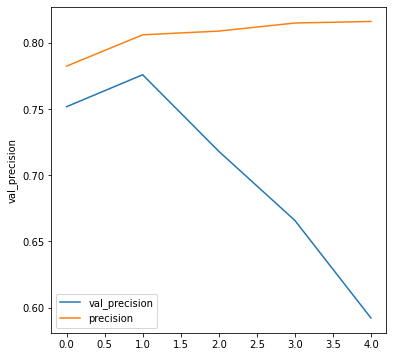

In [34]:
plt.figure(figsize = (6,6))
sns.lineplot(data = history_df["val_precision"], label = "val_precision")
sns.lineplot(data = history_df["precision"], label = "precision")
plt.show()

In [56]:
#итого модель показывает 84.1% precision
#следовательно, из всех наших сделок, в которые мы будем входить, 84.1 будут плюсовые